In [71]:
import numpy as np
from scipy.integrate import odeint
import torch
import torchdiffeq
import matplotlib.pyplot as plt
import cvxpy as cp

constrained = False
dim=10

In [72]:
c = torch.load('data/c.pt')
d = torch.load('data/d.pt')
A = torch.load('data/A.pt')
H = torch.load('data/H.pt')


def f(x, y):
    return torch.sin(c.T @ x + d.T @ y) + torch.log(torch.linalg.norm(x+y)**2 + 1)

def g(x, y):
    return 0.5 * torch.linalg.norm(H@y - A@x)**2

# def g(x, y):
#     return 0.5 * torch.linalg.norm(y + x)**2


In [73]:
def calc_derivatives(x, y):
    f_val = f(x,y)
    g_val = g(x,y)

    # 1st derivatives
    dfdy = torch.autograd.grad(f_val, y, create_graph=True)[0]
    dfdx = torch.autograd.grad(f_val, x, create_graph=True)[0]

    dgdy = torch.autograd.grad(g_val, y, create_graph=True)[0]
    dgdx = torch.autograd.grad(g_val, x, create_graph=True)[0]

    # Initialize tensors for 2nd derivatives
    dgdyy = torch.zeros((dim, dim))
    dgdyx = torch.zeros((dim, dim))
    # Compute 2nd derivatives element-wise
    for i in range(dgdy.shape[0]):
        dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True)[0][:, 0]
        dgdyx[i, :] = torch.autograd.grad(dgdy[i], x, retain_graph=True, create_graph=True)[0][:, 0]
    
    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx

In [90]:
def solveLL(x):
    # xx = x.clone().detach().requires_grad_(False)
    # y = cp.Variable((100, 1))
    # objective = cp.Minimize(g(xx, y, iscp=True))
    # problem = cp.Problem(objective)
    # result = problem.solve(solver=cp.SCS, eps=1e-3)
    # y = torch.Tensor(y.value)
    # y.requires_grad = True
    # return y
    # -----
    y = torch.randn((dim, 1), requires_grad=True, dtype=torch.float32)
    i = 0
    lr = 1e-1
    while True:
        i += 1
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        HessianInv = dgdyy.inverse()
        # print(torch.linalg.norm(dgdy, 2))
        if torch.linalg.norm(dgdy, 2) < 1e-3:
            break
        with torch.no_grad():
            y -= lr * HessianInv @ dgdy
    return y

# Define the system of ODEs
def system(t, variables):
    alpha = 1
    x, y = variables[:dim], variables[dim:]
    
    dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
    with torch.no_grad():    
        if inversionFree:
            if projectionMethod == 1:
                try: dxdt;
                except NameError: dxdt = torch.zeros_like(x) # Not defined yet
                a = 2 * dgdyy @ dgdy
                b = -2 * dgdy.T @ dgdyx @ dxdt - alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)

                d = a * torch.maximum(torch.Tensor([0]), -a.T @ dfdy - b) / torch.linalg.norm(a, 2)**2

                dxdt = -dfdx - dgdyx.T @ d
                dydt = -dfdy - d
            else:
                eta = 1
                a = 2 * dgdyx @ dgdy
                b = 2 * dgdyy @ dgdy
                c = -alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
                ab = torch.cat((a, b), 0)
                abeta = torch.cat((a, b/eta), 0)

                # tot = torch.cat((dfdx, dfdy), 0)
                tot = torch.cat((dfdx, dgdy), 0)
                d = abeta * torch.maximum(torch.Tensor([0]), -ab.T @ tot - c) / (torch.linalg.norm(a, 2)**2 + torch.linalg.norm(b, 2)**2 / eta)
                dtotdt = -tot - d
                dxdt = dtotdt[:dim]; dydt = dtotdt[dim:]
                
        else:
            gHessianInv = dgdyy.inverse()
            dxdt = -dfdx + dgdyx.T @ gHessianInv @ dfdy
            dydt = -gHessianInv @ (alpha * dgdy + dgdyx @ dxdt)    
    
    return torch.cat((dxdt, dydt), 0)

LL error:  tensor(0.0009, grad_fn=<AmaxBackward0>)
LL error:  tensor(0.0009, grad_fn=<AmaxBackward0>)
LL error:  tensor(0.0009, grad_fn=<AmaxBackward0>)


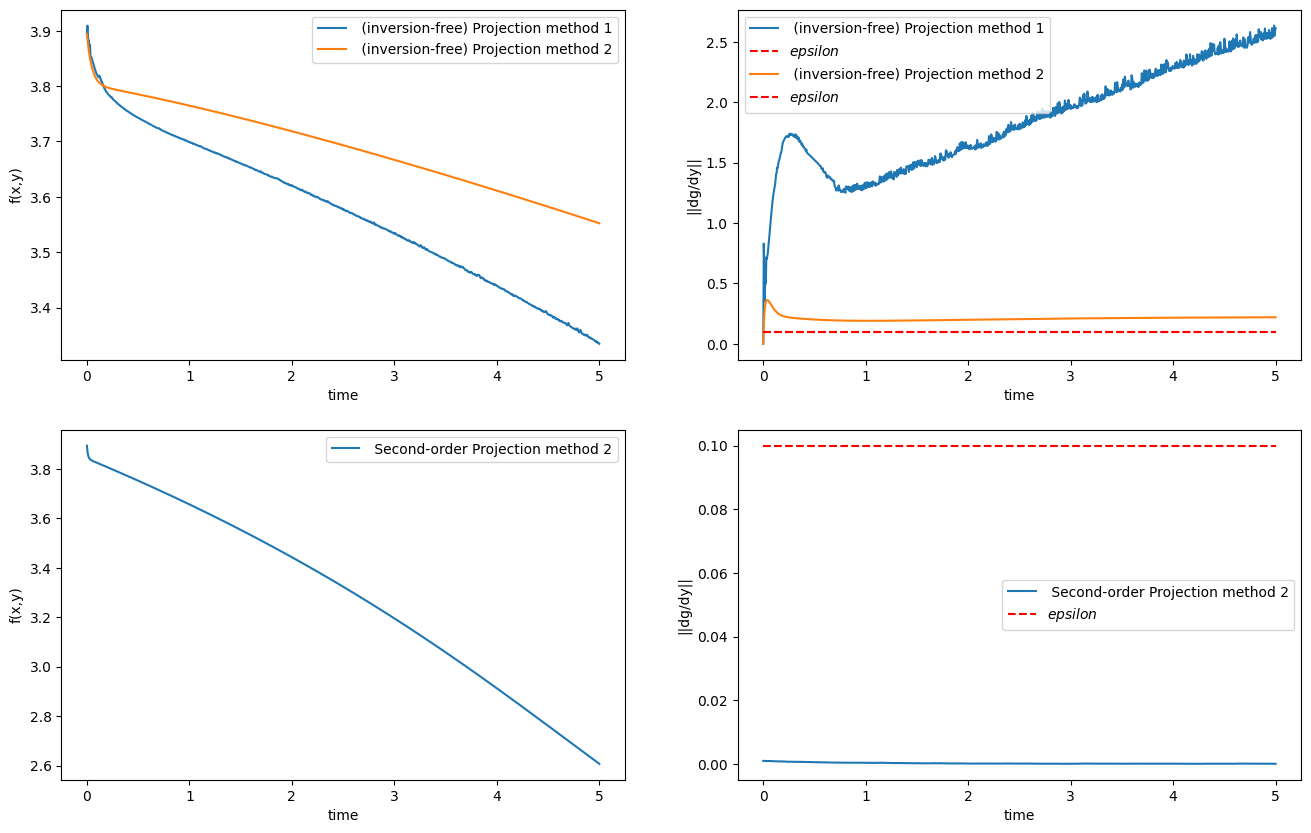

In [91]:
plt.figure(figsize=(16, 10))
epsilon = 1e-1

for (inversionFree, projectionMethod) in [(False, None), (True, 1), (True, 2)]:
    torch.manual_seed(0)
    x = torch.randn((dim, 1), requires_grad=True, dtype=torch.float32)
    y = solveLL(x)
    # 
    dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
    error = torch.linalg.norm(dgdy, 2)
    print('LL error: ', error)
    # Time points where the solution is computed
    t = torch.linspace(0, 5, 1000)

    # Solve the system of ODEs
    initial_conditions = torch.cat((x, y), 0)
    solution = torchdiffeq.odeint(system, initial_conditions, t, method='rk4')

    lossF, lossG, LLerror = [], [], []
    for i in range(len(solution)):
        lossF.append(f(solution[i, :dim], solution[i, dim:])[0].detach().numpy())
        __, __, __, dgdy, __, __ = calc_derivatives(solution[i, :dim], solution[i, dim:])
        lossG.append(torch.linalg.norm(dgdy).detach().numpy())

    plt.subplot(2, 2, (1 if inversionFree else 3))
    plt.plot(t, lossF, label= (' (inversion-free)' if inversionFree else ' Second-order') +\
                    (' Projection method 1' if projectionMethod == 1 else ' Projection method 2'))
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('f(x,y)')
    # -----------------------------------------------------
    plt.subplot(2, 2, 1 * (1 if inversionFree else 3) + 1)
    plt.plot(t, lossG, label=(' (inversion-free)' if inversionFree else ' Second-order') +\
                    (' Projection method 1' if projectionMethod == 1 else ' Projection method 2'))
    plt.plot(t, [epsilon] * len(t), 'r--', label='$epsilon$')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('||dg/dy||')


plt.show()

In [92]:
lossG[:5]

[array(0.00092098, dtype=float32),
 array(0.14583848, dtype=float32),
 array(0.23682243, dtype=float32),
 array(0.29294676, dtype=float32),
 array(0.32699448, dtype=float32)]